<a href="https://colab.research.google.com/github/steveseguin/measure_frequency_response/blob/main/Frequency_Response_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Setup: Install and Import Necessary Libraries
!pip install numpy scipy matplotlib

from google.colab import files
# Import additional libraries for parallel processing
import numpy as np
from scipy.io import wavfile
import matplotlib.pyplot as plt
from scipy.fft import rfft, rfftfreq
from google.colab import files
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import re
import concurrent.futures
import time
from functools import lru_cache
import psutil
import gc
def process_filename(filename):
    # Remove added numbers in parentheses and file extension
    filename = re.sub(r"\([0-9]+\)", "", filename)  # Remove (1), (2), etc.
    filename = re.sub(r"\.\w+$", "", filename)  # Remove file extension
    return filename

def load_audio(filename):
    samplerate, data = wavfile.read(filename)
    if data.ndim > 1:
        data = data.mean(axis=1)  # Convert to mono if stereo
    return samplerate, data

def load_calibration_file(filename):
    """Load calibration data from a file with better error handling and logging"""
    calibration_data = {}
    try:
        with open(filename, 'r') as f:
            for line in f:
                line = line.strip()
                if line and not line.startswith('#'):
                    parts = re.split(r'[\s,;]+', line)
                    if len(parts) >= 2:
                        try:
                            freq = float(parts[0])
                            val = float(parts[1])
                            calibration_data[freq] = val
                            print(f"Loaded calibration point: {freq} Hz -> {val} dB")
                        except ValueError:
                            print(f"Warning: Could not parse line: {line}")
    except Exception as e:
        print(f"Error loading calibration file: {str(e)}")

    print(f"Loaded {len(calibration_data)} calibration points from {filename}")
    return calibration_data

# Enhanced caching system with LRU cache
class EnhancedCache:
    def __init__(self, max_size=5):
        self.cache = {}
        self.max_size = max_size
        self.access_times = {}

    def get(self, key):
        if key in self.cache:
            self.access_times[key] = time.time()
            return self.cache[key]
        return None

    def set(self, key, value):
        if len(self.cache) >= self.max_size:
            # Remove least recently used item
            oldest_key = min(self.access_times.keys(), key=lambda k: self.access_times[k])
            del self.cache[oldest_key]
            del self.access_times[oldest_key]

        self.cache[key] = value
        self.access_times[key] = time.time()

    def clear(self):
        self.cache.clear()
        self.access_times.clear()

# Create enhanced FFT cache
fft_cache = EnhancedCache(max_size=10)

# Optimized FFT analysis with caching
def optimized_fft_analysis(data, samplerate, window=None, cache_key=None):
    """Optimized FFT analysis with better downsampling and caching"""
    if cache_key is not None:
        cached_result = fft_cache.get(cache_key)
        if cached_result is not None:
            return cached_result

    # Determine if downsampling is needed
    max_fft_length = 1_000_000
    if len(data) > max_fft_length:
        downsample_factor = len(data) // max_fft_length
        downsampled_data = data[::downsample_factor]
        effective_samplerate = samplerate / downsample_factor
    else:
        downsampled_data = data
        effective_samplerate = samplerate

    # Apply window
    if window is None:
        window = np.hanning(len(downsampled_data))
    elif len(window) != len(downsampled_data):
        window = np.hanning(len(downsampled_data))

    windowed_data = downsampled_data * window

    # Compute FFT efficiently
    fft_spectrum = rfft(windowed_data)
    freqs = rfftfreq(len(windowed_data), 1/effective_samplerate)
    magnitude = np.abs(fft_spectrum)

    result = (freqs, magnitude)

    # Cache the result
    if cache_key is not None:
        fft_cache.set(cache_key, result)

    return result

# Optimized adaptive smoothing (using improved version of fast_adaptive_smoothing)
def optimized_adaptive_smoothing(freqs, response, min_freq=50, max_freq=15000, octave_fraction=3, scale_factor=5):
    """
    Optimized implementation of adaptive smoothing using a pre-computed filter bank
    and better log spacing to avoid spikes between intervals.
    """
    # Only process data in the valid range
    valid_idx = (freqs >= min_freq) & (freqs <= max_freq)
    valid_freqs = freqs[valid_idx]
    valid_response = response[valid_idx]

    # Use more frequency points for smoother results (avoid spikes)
    log_min = np.log10(max(20, min_freq))
    log_max = np.log10(min(20000, max_freq))

    # Use more points for better resolution (reduces spikes)
    num_points = min(1000, len(valid_freqs))
    log_freqs = np.logspace(log_min, log_max, num_points)

    # Pre-calculate band centers
    band_centers = log_freqs
    smoothed = np.zeros_like(band_centers)

    # Vectorized computation of weights
    for i, center_freq in enumerate(band_centers):
        window_width = center_freq / octave_fraction
        half_width = window_width / 2

        # Calculate distances and weights using vectorized operations
        distances = np.abs(valid_freqs - center_freq) / half_width
        mask = distances <= 1.0

        if np.any(mask):
            weights = np.exp(-scale_factor * distances[mask])
            smoothed[i] = np.sum(valid_response[mask] * weights) / np.sum(weights)
        else:
            # Find nearest frequency if no points in window
            nearest_idx = np.argmin(np.abs(valid_freqs - center_freq))
            smoothed[i] = valid_response[nearest_idx]

    # Create smoother interpolation (use cubic for better transitions)
    interp_func = interp1d(band_centers, smoothed, kind='cubic',
                          bounds_error=False, fill_value=(smoothed[0], smoothed[-1]))

    # Apply to original frequency points to maintain exact frequency alignment
    result = np.copy(response)
    result[valid_idx] = interp_func(valid_freqs)

    # Apply light Savitzky-Golay filter to remove any remaining small artifacts
    if len(result[valid_idx]) > 10:  # Only if enough points
        window_length = min(11, len(result[valid_idx]) // 5 * 2 + 1)  # Must be odd
        if window_length >= 3:
            result[valid_idx] = savgol_filter(result[valid_idx], window_length, 3)

    return result

def calculate_frequency_response(test_mag, ref_mag, eps=1e-10):
    """Calculate the frequency response as the ratio between test and reference magnitudes"""
    # Ensure both arrays are the same length
    min_len = min(len(test_mag), len(ref_mag))
    test_mag = test_mag[:min_len]
    ref_mag = ref_mag[:min_len]

    # Calculate ratio in linear domain
    ratio = np.divide(test_mag, ref_mag + eps)  # Add epsilon to avoid division by zero

    # Convert to dB
    db_response = 20 * np.log10(ratio)

    return db_response

def normalize_for_pink_noise(freqs, magnitude):
    """Normalize frequency response to account for pink noise's natural 1/f falloff"""
    # Pink noise has 3dB/octave falloff (factor of roughly sqrt(f))
    normalization_factor = np.sqrt(freqs)
    normalized_magnitude = magnitude * normalization_factor
    return normalized_magnitude

def apply_calibration(freqs, magnitude, calibration_data):
    if not calibration_data:
        return magnitude

    calibrated_magnitude = magnitude.copy()

    # Get calibration frequencies and values as arrays for interpolation
    cal_freqs = np.array(list(calibration_data.keys()))
    cal_values = np.array(list(calibration_data.values()))

    # Create interpolation function (use log scale for frequency)
    interp_func = interp1d(
        np.log10(cal_freqs),
        cal_values,
        kind='cubic',
        bounds_error=False,
        fill_value=(cal_values[0], cal_values[-1])  # Extrapolate at endpoints
    )

    # Apply calibration to valid frequencies (avoid log(0))
    valid_indices = (freqs > 0)
    log_freqs = np.log10(freqs[valid_indices])

    # If calibration is in dB, convert to linear, apply, then back to dB
    calibration_factors = 10**(interp_func(log_freqs) / 20)  # Convert dB to linear gain
    calibrated_magnitude[valid_indices] *= calibration_factors

    return calibrated_magnitude

# Process a single microphone (for parallel processing)
def process_microphone(ref_file, test_file, calibration_file=None):
    start_time = time.time()
    print(f"Processing {test_file}...")

    # Process reference file
    samplerate_ref, data_ref = load_audio(ref_file)
    ref_hash = hash(data_ref.tobytes())
    freqs_ref, magnitude_ref = optimized_fft_analysis(data_ref, samplerate_ref,
                                                     cache_key=f"ref_{ref_hash}")

    # Process test file
    samplerate_test, data_test = load_audio(test_file)
    test_hash = hash(data_test.tobytes())
    freqs_test, magnitude_test = optimized_fft_analysis(data_test, samplerate_test,
                                                       cache_key=f"test_{test_hash}")

    # Apply calibration if available
    calibration_data = {}
    if calibration_file:
        calibration_data = load_calibration_file(calibration_file)
        magnitude_ref = apply_calibration(freqs_ref, magnitude_ref, calibration_data)

    # Calculate frequency response
    frequency_response = calculate_frequency_response(magnitude_test, magnitude_ref)

    # Define frequency limits
    lower_limit_freq = 20
    upper_limit_freq = 20000

    # Apply optimized smoothing (medium)
    print(f"  Applying medium smoothing for {test_file}...")
    smoothed_medium = optimized_adaptive_smoothing(
        freqs_ref, frequency_response,
        min_freq=lower_limit_freq, max_freq=upper_limit_freq,
        octave_fraction=3, scale_factor=4
    )

    # Apply optimized smoothing (heavy)
    print(f"  Applying heavy smoothing for {test_file}...")
    smoothed_heavy = optimized_adaptive_smoothing(
        freqs_ref, frequency_response,
        min_freq=lower_limit_freq, max_freq=upper_limit_freq,
        octave_fraction=1, scale_factor=3
    )

    # Downsample for plotting
    valid_indices = (freqs_ref >= lower_limit_freq) & (freqs_ref <= upper_limit_freq)
    valid_freqs = freqs_ref[valid_indices]

    target_size = 1000
    if len(valid_freqs) > target_size:
        ds_indices = np.round(np.linspace(0, len(valid_freqs)-1, target_size)).astype(int)
        ds_freqs = valid_freqs[ds_indices]
        ds_original = frequency_response[valid_indices][ds_indices]
        ds_medium = smoothed_medium[valid_indices][ds_indices]
        ds_heavy = smoothed_heavy[valid_indices][ds_indices]
    else:
        ds_freqs = valid_freqs
        ds_original = frequency_response[valid_indices]
        ds_medium = smoothed_medium[valid_indices]
        ds_heavy = smoothed_heavy[valid_indices]

    # Free memory
    del smoothed_medium, smoothed_heavy, data_ref, data_test
    gc.collect()

    # Return processed data
    end_time = time.time()
    print(f"  {test_file} processed in {end_time - start_time:.2f} seconds")

    ref_name = process_filename(ref_file)
    test_name = process_filename(test_file)
    calibration_status = "Calibrated" if calibration_file else "Not Calibrated"

    return {
        'freqs': ds_freqs,
        'original': ds_original,
        'medium': ds_medium,
        'heavy': ds_heavy,
        'ref_name': ref_name,
        'test_name': test_name,
        'calibration': calibration_status
    }

def fft_analysis(data, samplerate, window=None):
    if window is None:
        # Apply a Hann window by default for better frequency resolution
        window = np.hanning(len(data))

    windowed_data = data * window
    fft_spectrum = rfft(windowed_data)
    freqs = rfftfreq(len(data), 1/samplerate)
    magnitude = np.abs(fft_spectrum)
    return freqs, magnitude

# Process multiple microphones in parallel
def process_microphones_parallel(ref_file, test_files, calibration_file=None, max_workers=None):
    if max_workers is None:
        # Use number of cores minus 1 to avoid freezing the system
        max_workers = max(1, psutil.cpu_count(logical=False) - 1)

    results = []

    if len(test_files) == 1:
        # If only one test file, process it directly
        results.append(process_microphone(ref_file, test_files[0], calibration_file))
    else:
        # Process multiple files in parallel
        with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as executor:
            future_to_file = {
                executor.submit(process_microphone, ref_file, test_file, calibration_file): test_file
                for test_file in test_files
            }

            for future in concurrent.futures.as_completed(future_to_file):
                test_file = future_to_file[future]
                try:
                    result = future.result()
                    results.append(result)
                except Exception as e:
                    print(f"Error processing {test_file}: {e}")

    return results

# Memory-efficient plotting function
def plot_mic_comparisons(comparison_data, show_original=True, show_medium=True, show_heavy=True):
    plt.figure(figsize=(12, 8))
    colors = plt.cm.tab10.colors

    for i, data in enumerate(comparison_data):
        color_idx = i % len(colors)
        curve_color = colors[color_idx]
        curve_label = f"{data['test_name']} vs {data['ref_name']} ({data['calibration']})"

        # Plot original curve if requested
        if show_original:
            plt.semilogx(data['freqs'], data['original'],
                        alpha=0.15, linewidth=0.5, color=curve_color)

        # Plot medium smoothing if requested
        if show_medium:
            plt.semilogx(data['freqs'], data['medium'],
                        linestyle='--', linewidth=1.0, color=curve_color)

        # Plot heavy smoothing if requested
        if show_heavy:
            plt.semilogx(data['freqs'], data['heavy'],
                        linewidth=2.0, color=curve_color, label=curve_label)

    # Add octave markers
    octaves = [31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
    plt.xticks(octaves, [str(oct) for oct in octaves])

    # Add zero reference line
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)

    # Grid settings
    plt.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.7)
    plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

    # Add 10dB spacing lines
    for db in range(-50, 51, 10):
        plt.axhline(y=db, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)

    # Labels and title
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude (dB)')
    plt.title('Microphone Frequency Response Comparison')

    plt.legend()
    plt.tight_layout()

    return plt.gcf()

# Main function to run the entire process
def run_mic_comparison(ref_file, test_files, calibration_file=None, max_workers=None):
    start_time = time.time()
    print(f"Starting analysis of {len(test_files)} microphones...")

    # Process all microphones
    results = process_microphones_parallel(ref_file, test_files, calibration_file, max_workers)

    # Store results
    if 'mic_comparison_data' not in globals():
        globals()['mic_comparison_data'] = []

    # Add new results
    for result in results:
        globals()['mic_comparison_data'].append(result)

    # Plot all microphones
    fig = plot_mic_comparisons(globals()['mic_comparison_data'])

    end_time = time.time()
    print(f"Analysis completed in {end_time - start_time:.2f} seconds")

    return fig

# Optional: Create a simple UI for processing microphones
def create_mic_comparison_ui():
    from IPython.display import display
    import ipywidgets as widgets

    # Create file selection widgets
    ref_file_dropdown = widgets.Dropdown(description='Reference Mic:')
    test_files_select = widgets.SelectMultiple(description='Test Mic(s):')
    calibration_checkbox = widgets.Checkbox(description='Use Calibration', value=False)
    calibration_file_dropdown = widgets.Dropdown(description='Calibration File:')

    # Create processing button
    process_button = widgets.Button(description='Process Mics')

    # Create clear button
    clear_button = widgets.Button(description='Clear All', button_style='danger')

    # Create output widget
    output = widgets.Output()

    # Update file lists
    def update_file_lists():
        import os
        files = [f for f in os.listdir() if f.endswith(('.wav', '.WAV'))]
        cal_files = [f for f in os.listdir() if f.endswith(('.txt', '.cal'))]

        ref_file_dropdown.options = files
        test_files_select.options = files
        calibration_file_dropdown.options = cal_files

    # Process button callback
    def on_process_button_clicked(b):
        with output:
            if not ref_file_dropdown.value:
                print("Please select a reference microphone")
                return

            if not test_files_select.value:
                print("Please select at least one test microphone")
                return

            calibration_file = None
            if calibration_checkbox.value and calibration_file_dropdown.value:
                calibration_file = calibration_file_dropdown.value

            run_mic_comparison(ref_file_dropdown.value, list(test_files_select.value), calibration_file)

    # Clear button callback
    def on_clear_button_clicked(b):
        with output:
            globals()['mic_comparison_data'] = []
            print("All comparison data cleared!")

    # Connect callbacks
    process_button.on_click(on_process_button_clicked)
    clear_button.on_click(on_clear_button_clicked)

    # Update file lists
    update_file_lists()

    # Create layout
    file_selection_box = widgets.VBox([
        ref_file_dropdown,
        test_files_select,
        widgets.HBox([calibration_checkbox, calibration_file_dropdown]),
        widgets.HBox([process_button, clear_button])
    ])

    # Display the UI
    display(file_selection_box)
    display(output)

# Ensure backwards compatibility
memory_efficient_adaptive_smoothing = optimized_adaptive_smoothing
cached_fft_analysis = optimized_fft_analysis

In [ ]:
# Upload Audio Files
print("Upload your reference audio file (with a known flat-response microphone recording):")
uploaded_ref = files.upload()
reference_filename = list(uploaded_ref.keys())[0]
samplerate_ref, data_ref_unclipped = load_audio(reference_filename)
reference_filename_processed = process_filename(reference_filename)
data_ref = None # clear
uploaded_calibration = None # clear

Upload your reference audio file (with a known flat-response microphone recording):


Saving EMM-6.wav to EMM-6 (2).wav


In [ ]:
print("Upload your test microphone audio file:")
uploaded_test = files.upload()
test_filename = list(uploaded_test.keys())[0]
samplerate_test, data_test_unclipped = load_audio(test_filename)
test_filename_processed = process_filename(test_filename)
data_test = None # clear

Upload your test microphone audio file:


Saving X3-Padded.wav to X3-Padded.wav


In [ ]:
# Trim to match lengths
min_length = min(len(data_ref_unclipped), len(data_test_unclipped))
data_ref = data_ref_unclipped[:min_length]
data_test = data_test_unclipped[:min_length]

# Apply window before FFT for better frequency resolution
window = np.hanning(min_length)

# Calculate the Frequency Response
freqs_ref, magnitude_ref = fft_analysis(data_ref, samplerate_ref)
freqs_test, magnitude_test = fft_analysis(data_test, samplerate_test)

calibration_data = {}
calibration_status = "Not Calibrated"

In [ ]:

# This step is only if you have a calibration file
try:
    print("Upload your reference mic's calibration file (if available, otherwise skip):")
    uploaded_calibration = files.upload()

    if uploaded_calibration:
        calibration_filename = list(uploaded_calibration.keys())[0]
        calibration_data = load_calibration_file(calibration_filename)

        if calibration_data:
            # Apply calibration to reference mic spectrum
            magnitude_ref = apply_calibration(freqs_ref, magnitude_ref, calibration_data)
            calibration_status = "Calibrated"
            print(f"Calibration applied with {len(calibration_data)} data points")
        else:
            print("Warning: Calibration file was empty or could not be parsed")
except Exception as e:
    print(f"No calibration file uploaded or error: {str(e)}")

Upload your reference mic's calibration file (if available, otherwise skip):


Saving 28821.txt to 28821 (5).txt
Loaded calibration point: 20.0 Hz -> -0.1 dB
Loaded calibration point: 20.55 Hz -> -0.1 dB
Loaded calibration point: 21.11 Hz -> 0.0 dB
Loaded calibration point: 21.69 Hz -> 0.0 dB
Loaded calibration point: 22.29 Hz -> 0.0 dB
Loaded calibration point: 22.9 Hz -> 0.0 dB
Loaded calibration point: 23.53 Hz -> 0.0 dB
Loaded calibration point: 24.18 Hz -> 0.1 dB
Loaded calibration point: 24.84 Hz -> 0.1 dB
Loaded calibration point: 25.52 Hz -> 0.1 dB
Loaded calibration point: 26.22 Hz -> 0.1 dB
Loaded calibration point: 26.94 Hz -> 0.2 dB
Loaded calibration point: 27.68 Hz -> 0.2 dB
Loaded calibration point: 28.44 Hz -> 0.2 dB
Loaded calibration point: 29.22 Hz -> 0.2 dB
Loaded calibration point: 30.03 Hz -> 0.3 dB
Loaded calibration point: 30.85 Hz -> 0.3 dB
Loaded calibration point: 31.7 Hz -> 0.4 dB
Loaded calibration point: 32.57 Hz -> 0.4 dB
Loaded calibration point: 33.46 Hz -> 0.4 dB
Loaded calibration point: 34.38 Hz -> 0.5 dB
Loaded calibration poi

In [ ]:
# Create global storage if not already existing
if 'mic_comparison_data' not in globals():
    globals()['mic_comparison_data'] = []

if 'fft_cache' not in globals():
    globals()['fft_cache'] = {}

# Add clear button functionality
if 'clear_button' not in globals():
    from IPython.display import display, clear_output
    import ipywidgets as widgets

    def clear_comparison_data(b):
        globals()['mic_comparison_data'] = []
        clear_output(wait=True)
        display(globals()['clear_button'])
        print("All comparison data cleared!")

    clear_button = widgets.Button(
        description='Clear All Comparisons',
        button_style='danger'
    )
    clear_button.on_click(clear_comparison_data)
    globals()['clear_button'] = clear_button

# Display the button
display(globals()['clear_button'])

print("Calculating frequency responses...")
# Calculate frequency response (ratio of test to reference)
magnitude_ref_normalized = normalize_for_pink_noise(freqs_ref, magnitude_ref)
magnitude_test_normalized = normalize_for_pink_noise(freqs_test, magnitude_test)

frequency_response = calculate_frequency_response(magnitude_test_normalized, magnitude_ref_normalized)

# Define frequency limits
lower_limit_freq = 20     # Lower frequency limit in Hz
upper_limit_freq = 20000  # Upper frequency limit in Hz

# Filter to frequency range of interest
valid_indices = (freqs_ref >= lower_limit_freq) & (freqs_ref <= upper_limit_freq)
filtered_freqs = freqs_ref[valid_indices]
filtered_response = frequency_response[valid_indices]

# Apply adaptive smoothing with better parameters for audio analysis
print("Starting medium smoothing...")
smoothed_response_medium = optimized_adaptive_smoothing(
    freqs_ref,
    frequency_response,
    min_freq=lower_limit_freq,
    max_freq=upper_limit_freq,
    octave_fraction=6,    # Increase resolution for finer control (1/6 octave)
    scale_factor=3        # Reduced to avoid over-smoothing
)
print("Medium smoothing complete.")

print("Starting heavy smoothing...")
smoothed_response_heavy = optimized_adaptive_smoothing(
    freqs_ref,
    frequency_response,
    min_freq=lower_limit_freq,
    max_freq=upper_limit_freq,
    octave_fraction=2,    # Less aggressive smoothing (1/2 octave)
    scale_factor=2        # Reduced scale factor for more consistency
)
print("Heavy smoothing complete.")

# Filter to frequency range of interest
valid_indices = (freqs_ref >= lower_limit_freq) & (freqs_ref <= upper_limit_freq)
valid_freqs = freqs_ref[valid_indices]

# Downsample for plotting to save memory
target_size = 1000
if len(valid_freqs) > target_size:
    ds_indices = np.round(np.linspace(0, len(valid_freqs)-1, target_size)).astype(int)
    ds_freqs = valid_freqs[ds_indices]
    ds_original = frequency_response[valid_indices][ds_indices]
    ds_medium = smoothed_response_medium[valid_indices][ds_indices]
    ds_heavy = smoothed_response_heavy[valid_indices][ds_indices]
else:
    ds_freqs = valid_freqs
    ds_original = frequency_response[valid_indices]
    ds_medium = smoothed_response_medium[valid_indices]
    ds_heavy = smoothed_response_heavy[valid_indices]

# Free memory
del smoothed_response_heavy, smoothed_response_medium
gc.collect()

# Store the downsampled data
globals()['mic_comparison_data'].append({
    'freqs': ds_freqs,
    'original': ds_original,
    'medium': ds_medium,
    'heavy': ds_heavy,
    'ref_name': reference_filename_processed,
    'test_name': test_filename_processed,
    'calibration': calibration_status
})

Button(button_style='danger', description='Clear All Comparisons', style=ButtonStyle())

Calculating frequency responses...
Starting medium smoothing...


<ipython-input-1-da38d1d21552>:190: RuntimeWarning: divide by zero encountered in log10
  db_response = 20 * np.log10(ratio)


Medium smoothing complete.
Starting heavy smoothing...
Heavy smoothing complete.


Plotting data...


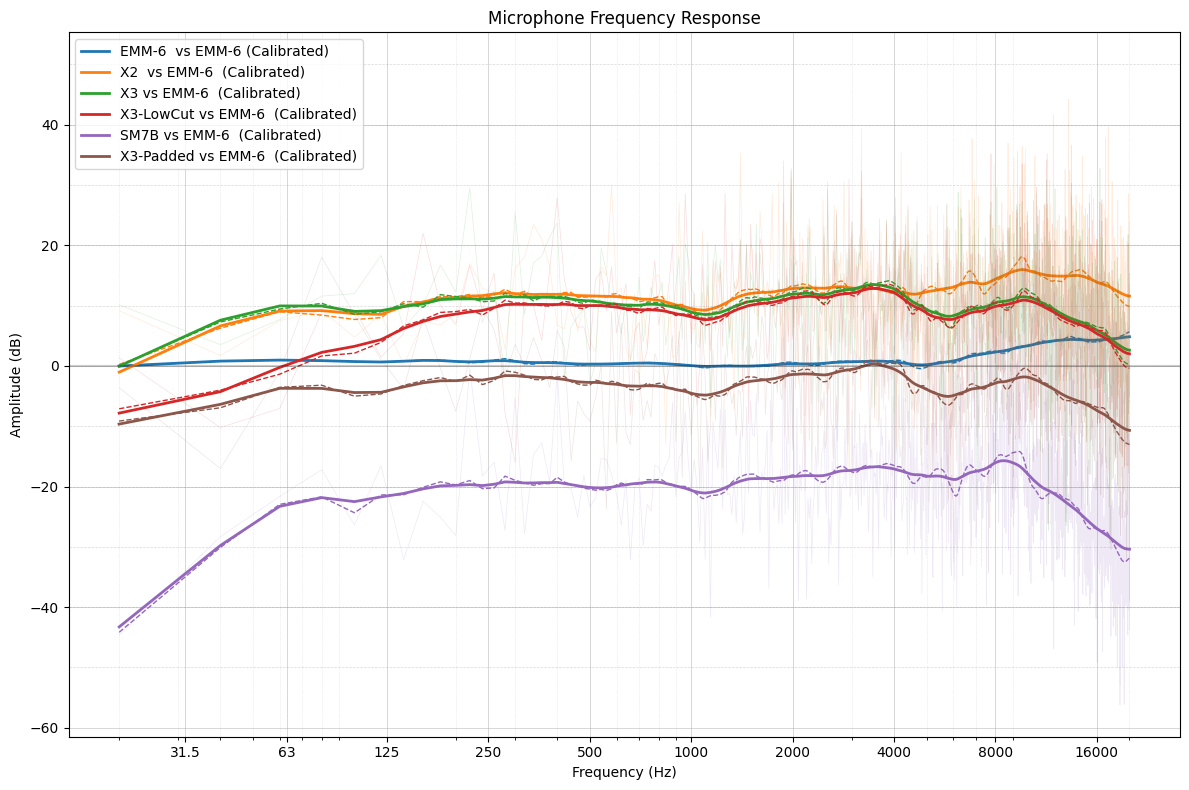

In [ ]:
# Memory efficient plotting - plot one line at a time and clear memory
plt.figure(figsize=(12, 8))
colors = plt.cm.tab10.colors

print("Plotting data...")
for i, data in enumerate(globals()['mic_comparison_data']):
    color_idx = i % len(colors)
    curve_color = colors[color_idx]
    curve_label = f"{data['test_name']} vs {data['ref_name']} ({data['calibration']})"

    # Plot one curve at a time to reduce memory usage
    plt.semilogx(data['freqs'], data['original'],
                 alpha=0.15, linewidth=0.5, color=curve_color)

    plt.semilogx(data['freqs'], data['medium'],
                 linestyle='--', linewidth=1.0, color=curve_color)

    plt.semilogx(data['freqs'], data['heavy'],
                 linewidth=2.0, color=curve_color, label=curve_label)

# Add octave markers
octaves = [31.5, 63, 125, 250, 500, 1000, 2000, 4000, 8000, 16000]
plt.xticks(octaves, [str(oct) for oct in octaves])

# Add zero reference line
plt.axhline(y=0, color='k', linestyle='-', alpha=0.2)

# Grid settings
plt.grid(which='major', linestyle='-', linewidth=0.5, alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, alpha=0.4)

# Add 10dB spacing lines
for db in range(-50, 51, 10):
    plt.axhline(y=db, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)

# Labels and title
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude (dB)')
plt.title('Microphone Frequency Response')

# Add the legend
plt.legend()
plt.tight_layout()
plt.show()